# Keras ResNet classifier for CIFAR10 test
ResNet network for CIFAR10 network test

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from data_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import tensorflow as tf 
from keras import backend as k
import os
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.allow_growth = True
k.tensorflow_backend.set_session(tf.Session(config=config))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# get data
cifar10_data = CIFAR10Data()
x_train, y_train, x_test, y_test = cifar10_data.get_data(subtract_mean=True)

num_train = int(x_train.shape[0] * 0.8)
num_val = x_train.shape[0] - num_train
mask = list(range(num_train, num_train+num_val))
x_val = x_train[mask]
y_val = y_train[mask]

mask = list(range(num_train))
x_train = x_train[mask]
y_train = y_train[mask]
print(x_train.shape)

CIFAR10 Training data shape: (50000, 32, 32, 3)
CIFAR10 Training label shape (50000, 1)
CIFAR10 Test data shape (10000, 32, 32, 3)
CIFAR10 Test label shape (10000, 1)
(40000, 32, 32, 3)


In [15]:
from classifiers.ResNet import ResNet18
from keras import losses
from keras import optimizers

weight_decay = 5e-4
lr = 1e-2
num_classes = 10
resnet18 = ResNet18(input_shape=(32, 32, 3), classes=num_classes, weight_decay=weight_decay)
opt = optimizers.SGD(lr=lr, momentum=0.9, nesterov=False)
resnet18.compile(optimizer=opt,
                 loss=losses.categorical_crossentropy,
                 metrics=['accuracy'])
resnet18.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 32, 32, 64)   1728        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 32, 32, 64)   192         conv2d_41[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 32, 32, 64)   0           batch_normalization_41[0][0]     
__________________________________________________________________________________________________
conv2d_42 

In [16]:
%%time
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
# fit data with data augmentation or not
data_augmentation = True


def lr_scheduler(epoch):
    new_lr = lr * (0.5 ** (epoch // 30))
    print('new lr:%.2e' % new_lr)
    return new_lr 

reduce_lr = LearningRateScheduler(lr_scheduler)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=10, min_lr=1e-6, verbose=1)

batch_size = 64
epochs = 200

if data_augmentation:
    # datagen
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False, # randomly flip images
    ) 
    # (std, mean, and principal components if ZCA whitening is applied).
    # datagen.fit(x_train)
    print('train with data augmentation')
    history = resnet18.fit_generator(generator=datagen.flow(x_train, y_train, batch_size=batch_size),
                                     epochs=epochs,
                                     callbacks=[reduce_lr],
                                     validation_data=(x_val, y_val)
                                    )
else:
    print('train without data augmentation')
    history = resnet18.fit(x_train, y_train, 
                           batch_size=batch_size, epochs=epochs, 
                           callbacks=[reduce_lr],
                           validation_data=(x_val, y_val)
                          )

train with data augmentation
Epoch 1/200
new lr:1.00e-02
625/625 [==============================] - 56s 90ms/step - loss: 3.2598 - acc: 0.4440 - val_loss: 2.8240 - val_acc: 0.5716
Epoch 2/200
new lr:1.00e-02
625/625 [==============================] - 45s 72ms/step - loss: 2.6323 - acc: 0.6129 - val_loss: 2.9295 - val_acc: 0.5791
Epoch 3/200
new lr:1.00e-02
625/625 [==============================] - 45s 72ms/step - loss: 2.2652 - acc: 0.6959 - val_loss: 2.4302 - val_acc: 0.6593
Epoch 4/200
new lr:1.00e-02
625/625 [==============================] - 46s 74ms/step - loss: 2.0120 - acc: 0.7423 - val_loss: 2.0204 - val_acc: 0.7251
Epoch 5/200
new lr:1.00e-02
625/625 [==============================] - 44s 70ms/step - loss: 1.8200 - acc: 0.7684 - val_loss: 1.7275 - val_acc: 0.7860
Epoch 6/200
new lr:1.00e-02
625/625 [==============================] - 46s 74ms/step - loss: 1.6539 - acc: 0.7898 - val_loss: 1.7517 - val_acc: 0.7456
Epoch 7/200
new lr:1.00e-02
625/625 [============================

Epoch 55/200
new lr:5.00e-03
625/625 [==============================] - 45s 72ms/step - loss: 0.3832 - acc: 0.9527 - val_loss: 0.7611 - val_acc: 0.8643
Epoch 56/200
new lr:5.00e-03
625/625 [==============================] - 43s 70ms/step - loss: 0.3846 - acc: 0.9513 - val_loss: 0.7366 - val_acc: 0.8592
Epoch 57/200
new lr:5.00e-03
625/625 [==============================] - 45s 71ms/step - loss: 0.3730 - acc: 0.9562 - val_loss: 0.6280 - val_acc: 0.8900
Epoch 58/200
new lr:5.00e-03
625/625 [==============================] - 44s 71ms/step - loss: 0.3793 - acc: 0.9527 - val_loss: 0.6735 - val_acc: 0.8776
Epoch 59/200
new lr:5.00e-03
625/625 [==============================] - 44s 70ms/step - loss: 0.3713 - acc: 0.9562 - val_loss: 0.7063 - val_acc: 0.8827
Epoch 60/200
new lr:5.00e-03
625/625 [==============================] - 44s 70ms/step - loss: 0.3772 - acc: 0.9541 - val_loss: 0.6649 - val_acc: 0.8862
Epoch 61/200
new lr:2.50e-03
625/625 [==============================] - 44s 71ms/step - 

Epoch 109/200
new lr:1.25e-03
625/625 [==============================] - 48s 77ms/step - loss: 0.1548 - acc: 0.9947 - val_loss: 0.4934 - val_acc: 0.9209
Epoch 110/200
new lr:1.25e-03
625/625 [==============================] - 47s 75ms/step - loss: 0.1536 - acc: 0.9945 - val_loss: 0.4860 - val_acc: 0.9226
Epoch 111/200
new lr:1.25e-03
625/625 [==============================] - 47s 75ms/step - loss: 0.1520 - acc: 0.9947 - val_loss: 0.5166 - val_acc: 0.9158
Epoch 112/200
new lr:1.25e-03
625/625 [==============================] - 54s 86ms/step - loss: 0.1498 - acc: 0.9950 - val_loss: 0.5036 - val_acc: 0.9170
Epoch 113/200
new lr:1.25e-03
625/625 [==============================] - 46s 74ms/step - loss: 0.1512 - acc: 0.9939 - val_loss: 0.5091 - val_acc: 0.9151
Epoch 114/200
new lr:1.25e-03
625/625 [==============================] - 49s 78ms/step - loss: 0.1510 - acc: 0.9932 - val_loss: 0.4889 - val_acc: 0.9188
Epoch 115/200
new lr:1.25e-03
625/625 [==============================] - 49s 78ms/

625/625 [==============================] - 46s 73ms/step - loss: 0.0982 - acc: 0.9994 - val_loss: 0.4013 - val_acc: 0.9366
Epoch 163/200
new lr:3.13e-04
625/625 [==============================] - 43s 69ms/step - loss: 0.0974 - acc: 0.9997 - val_loss: 0.3925 - val_acc: 0.9369
Epoch 164/200
new lr:3.13e-04
625/625 [==============================] - 46s 74ms/step - loss: 0.0974 - acc: 0.9995 - val_loss: 0.3938 - val_acc: 0.9363
Epoch 165/200
new lr:3.13e-04
625/625 [==============================] - 47s 75ms/step - loss: 0.0971 - acc: 0.9996 - val_loss: 0.4005 - val_acc: 0.9374
Epoch 166/200
new lr:3.13e-04
625/625 [==============================] - 45s 71ms/step - loss: 0.0964 - acc: 0.9997 - val_loss: 0.4007 - val_acc: 0.9370
Epoch 167/200
new lr:3.13e-04
625/625 [==============================] - 45s 72ms/step - loss: 0.0959 - acc: 0.9996 - val_loss: 0.4005 - val_acc: 0.9381
Epoch 168/200
new lr:3.13e-04
625/625 [==============================] - 45s 72ms/step - loss: 0.0960 - acc: 0.9

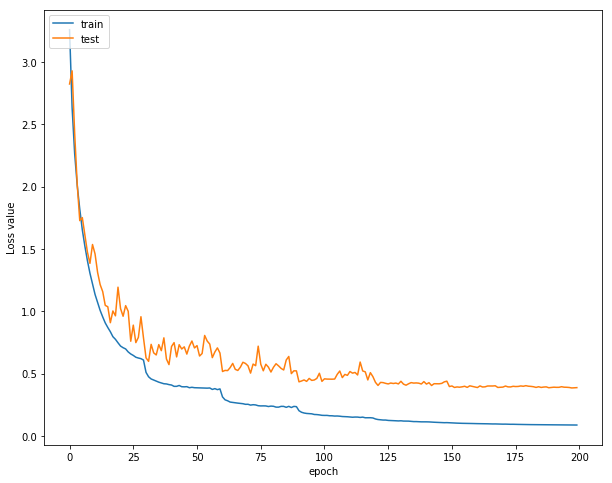

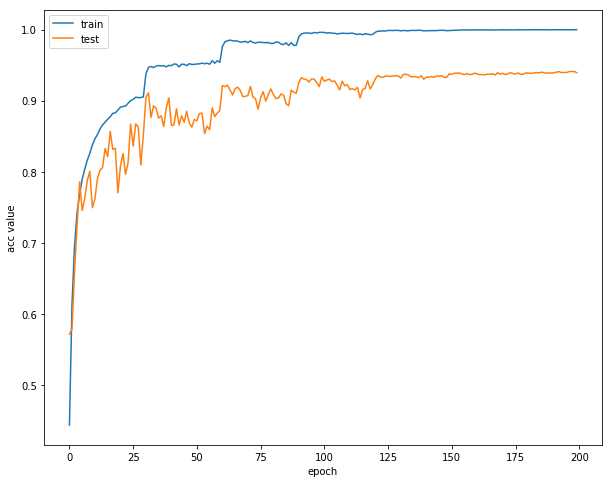

In [17]:
# plot loss and acc 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('Loss value')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('acc value')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
loss, acc = resnet18.evaluate(x_test, y_test)
print('evaluate loss:%f acc:%f' % (loss, acc))

10000/10000 [==============================] - 6s 568us/step
evaluate loss:0.420864 acc:0.934700
